In [ ]:
from keras.datasets import mnist

In [ ]:
pip install -U scikit-image

In [ ]:
!pip install numba

# Phase 1: Image Filtering

In [ ]:
from skimage.exposure import rescale_intensity
from numba import jit, prange
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import torchvision.transforms as transforms
from torchvision import datasets
import pandas as pd
import matplotlib.pyplot as plt

Convolve function:

In [ ]:
@jit(nopython=True, parallel=True, fastmath=True)
def convolve_numba(image, kernel):
    (image_Height, image_Width) = image.shape[:2]
    (kernel_Height, kernel_Width) = kernel.shape[:2]
    pad = (kernel_Width - 1) // 2

    # Create zero-padded image
    image_padded = np.zeros((image_Height + 2 * pad, image_Width + 2 * pad), dtype=image.dtype)
    image_padded[pad:-pad, pad:-pad] = image

    output = np.zeros((image_Height, image_Width), dtype="float32")

    # Parallelize the loop using Numba's prange
    for y in prange(pad, image_Height + pad):
        for x in range(pad, image_Width + pad):
            roi = image_padded[y - pad:y + pad + 1, x - pad:x + pad + 1]
            output[y - pad, x - pad] = np.sum(roi * kernel)

    return output

Definition of kernels for filters

In [ ]:
# Define kernels
sobelX = np.array((
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]), dtype="int")

sobelY = np.array((
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]), dtype="int")

sharpen = np.array((
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]), dtype="int")

Sobel Implementation


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Combined dataset shape: (70000, 28, 28)
Combined labels shape: (70000,)


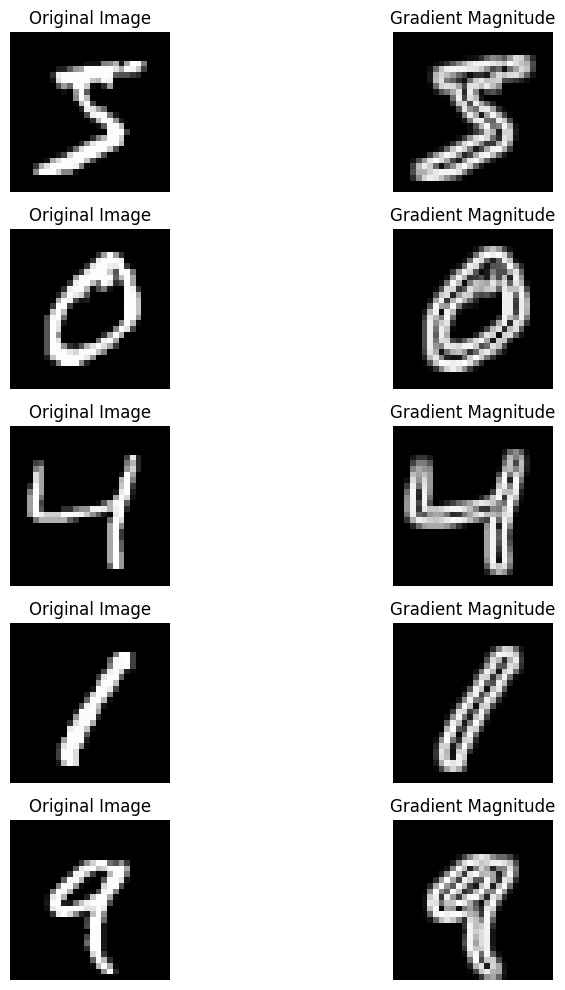

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_full = np.concatenate((x_train, x_test), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)

print(f"Combined dataset shape: {x_full.shape}")
print(f"Combined labels shape: {y_full.shape}")
gradient_magnitudes = []

for i in range(len(x_full)):
    image = x_full[i].astype('float32')
    image /= 255.0

    # Apply Sobel filters and compute gradient magnitude
    Gx = convolve_numba(image, sobelX)
    Gy = convolve_numba(image, sobelY)
    G = np.sqrt(Gx**2 + Gy**2)

    gradient_magnitudes.append(G)


def visualize_samples(original_images, gradient_images, num_samples=5):
    plt.figure(figsize=(10, num_samples * 2))
    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(original_images[i], cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        # Gradient magnitude image
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(gradient_images[i], cmap="gray")
        plt.title("Gradient Magnitude")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_samples(x_full[:5], gradient_magnitudes[:5])
# Flatten gradient magnitudes and store them in a list
flattened_gradients = [G.flatten() for G in gradient_magnitudes]
# Convert to a NumPy array for further processing
flattened_gradients = np.array(flattened_gradients)

HOG implementation:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from keras.datasets import mnist
from joblib import Parallel, delayed

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Combine train and test data
x_full = np.concatenate((x_train, x_test), axis=0)

# Function to compute HOG for a single image
def compute_hog(image):
    return hog(image,
               orientations=9,
               pixels_per_cell=(8, 8),
               cells_per_block=(1, 1),
               visualize=False,
               feature_vector=True)

# Parallel computation of HOG features
hog_features = Parallel(n_jobs=-1, batch_size=100)(
    delayed(compute_hog)(img) for img in x_full
)
hog_features = np.array(hog_features)

# Confirm the shape of HOG features
print("HOG features shape:", hog_features.shape)

HOG features shape: (70000, 81)


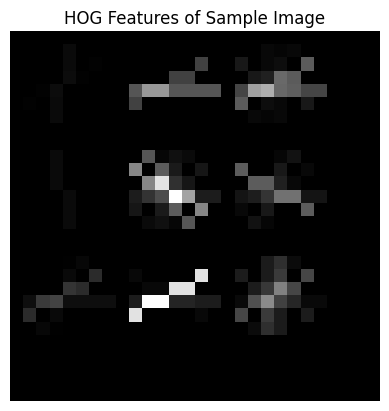

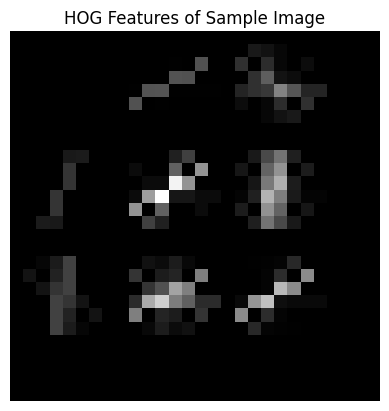

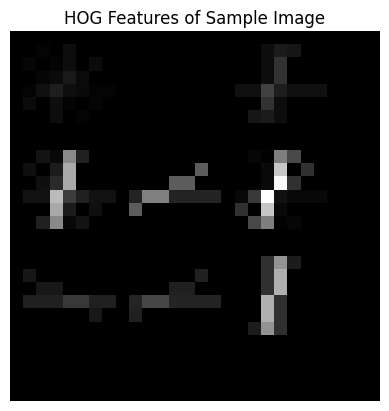

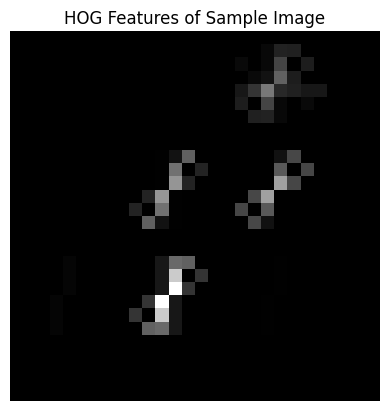

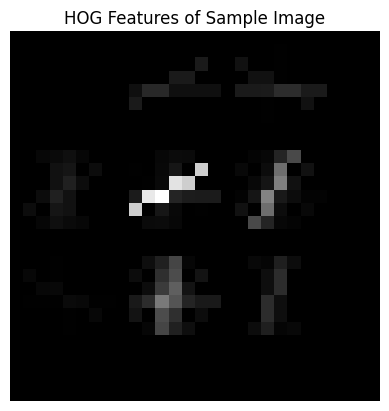

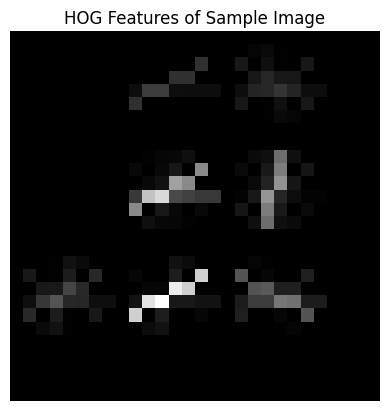

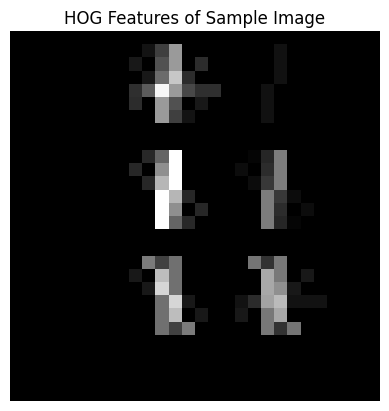

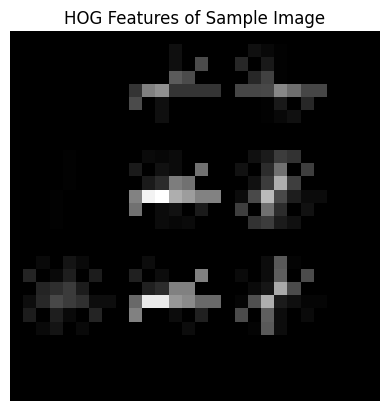

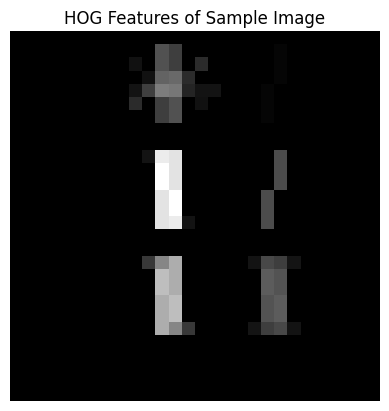

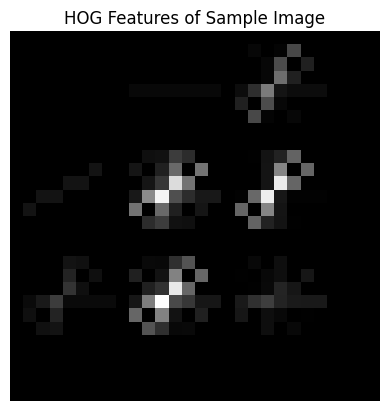

In [ ]:
# Visualize the first image's HOG features
samples = 10

for i in range (samples):
    fd, hog_image = hog(x_full[i],
                        orientations=9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1),
                        visualize=True)

    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG Features of Sample Image")
    plt.axis("off")
    plt.show()

Concatenation of HOG features and Sobel features

In [ ]:
Sobel_HOG_Features = np.concatenate((flattened_gradients, hog_features),axis = 1)
print(Sobel_HOG_Features.shape)

(70000, 865)


Implementation of Sharpen:

Combined dataset shape: (70000, 28, 28)
Combined labels shape: (70000,)


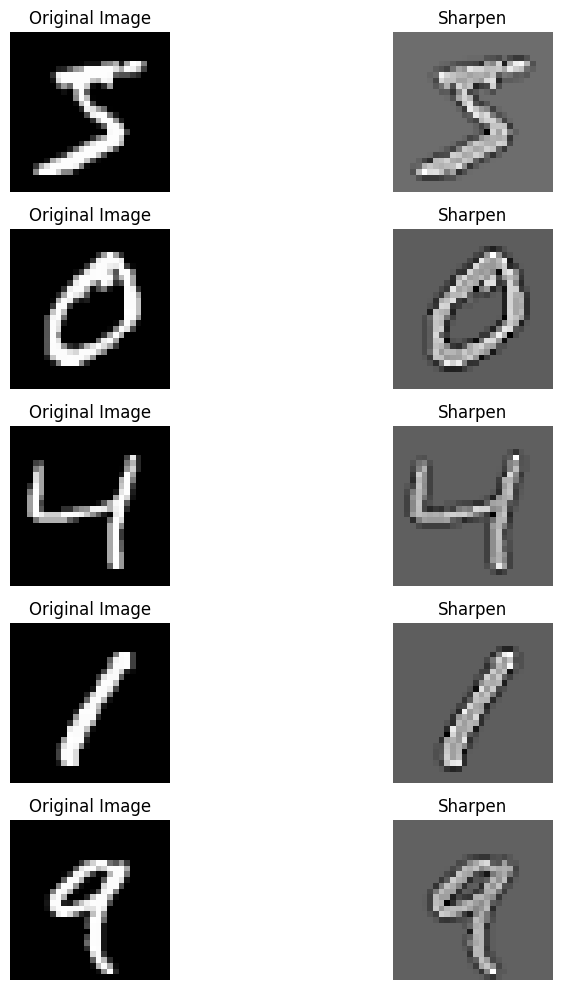

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_full = np.concatenate((x_train, x_test), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)

print(f"Combined dataset shape: {x_full.shape}")
print(f"Combined labels shape: {y_full.shape}")
Sharpen_Features = []

for i in range(len(x_full)):
    image = x_full[i].astype('float32')
    image /= 255.0

    # Apply Sharpen filter on images
    S = convolve_numba(image, sharpen)

    Sharpen_Features.append(S)

# Visualization
def visualize_samples(original_images, Sharpen_Features, num_samples=5):
    plt.figure(figsize=(10, num_samples * 2))
    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(original_images[i], cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        # Sharpened image
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(Sharpen_Features[i], cmap="gray")
        plt.title("Sharpen")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_samples(x_full[:5], Sharpen_Features[:5])

# Flatten gradient magnitudes and store them in a list
flattened_Sharpened_Features = [S.flatten() for S in Sharpen_Features]
# Convert to a NumPy array for further processing
flattened_Sharpened_Features = np.array(flattened_Sharpened_Features)

Concatenation of HOG features and Sharpen features

In [ ]:
Sharpen_HOG_Features = np.concatenate((flattened_Sharpened_Features, hog_features),axis = 1)
print(Sharpen_HOG_Features.shape)

(70000, 865)


# Phase 2: Image Centering and PCA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math

def pca(x_full):
    # Check if the input data is 2D; if not, reshape to (num_samples, num_features)
    if x_full.ndim != 2:
        num_samples = x_full.shape[0]
        num_features = np.prod(x_full.shape[1:])
        x_full = x_full.reshape(num_samples, num_features)
        print(f"Reshaped input data to (num_samples, {num_features}) for PCA.")

    # Center the data
    mean_image = np.mean(x_full, axis=0)
    x_full_centered = x_full - mean_image

    # ---->  Change the reshape logic to handle non-square images
    # Calculate the closest square shape that can accommodate the features
    side_length = int(math.ceil(math.sqrt(x_full.shape[1])))

    # ----> Reshape to closest square, and pad if necessary
    num_pixels = side_length * side_length
    mean_image_reshaped = np.pad(mean_image, (0, num_pixels - len(mean_image)), 'constant').reshape(side_length, side_length)

    # Visualize the mean image
    plt.figure(figsize=(2, 2))
    plt.title("Mean Image")
    plt.imshow(mean_image_reshaped, cmap="gray")
    plt.axis("off")
    plt.show()

    # Visualize some centered images
    # Visualize some samples from the original dataset
    num_samples_to_plot = 5  # Number of samples to visualize
    sample_images = x_full_centered[:num_samples_to_plot]

    # Reshape and pad each sample for visualization
    reshaped_samples = []
    for sample in sample_images:
        padded_sample = np.pad(sample, (0, num_pixels - len(sample)), 'constant')  # Pad to match square shape
        reshaped_sample = padded_sample.reshape(side_length, side_length)
        reshaped_samples.append(reshaped_sample)

    # Plot the samples
    fig, axes = plt.subplots(1, num_samples_to_plot, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(reshaped_samples[i], cmap="gray")
        ax.set_title(f"Sample {i+1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


    # Apply PCA to the centered dataset
    pca = PCA()
    x_full_pca = pca.fit_transform(x_full_centered)

    # Determine number of components explaining ~80% variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    n_components = np.argmax(cumulative_variance >= 0.80) + 1
    print(f"Number of components explaining ~80% variance: {n_components}")

    # Reduce data to optimal dimensions
    pca = PCA(n_components=n_components)
    x_full_reduced = pca.fit_transform(x_full_centered)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.title("Scree Plot")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid

    return x_full_reduced

Implementing PCA on Raw Data:

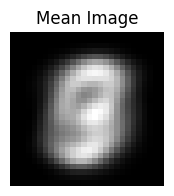

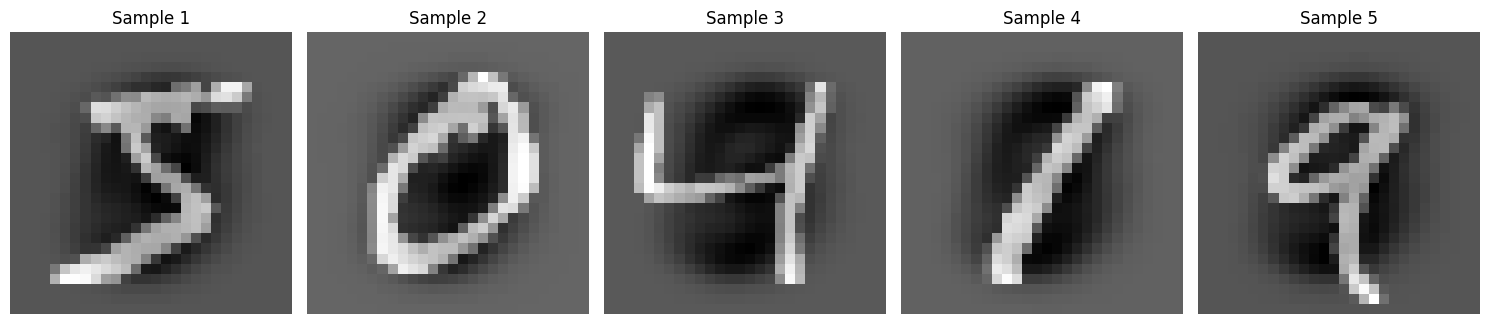

Number of components explaining ~80% variance: 43


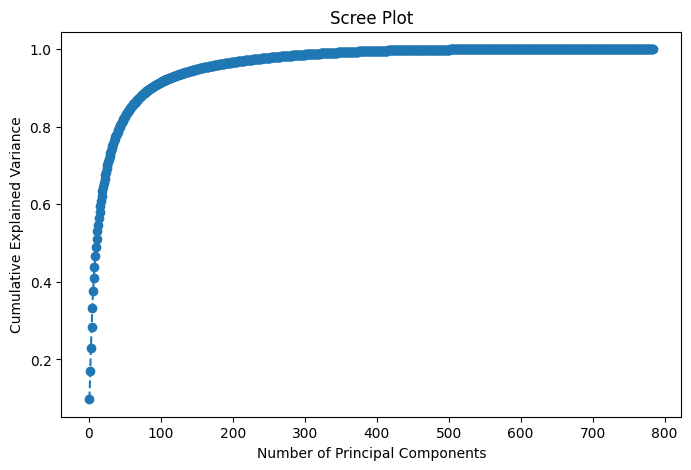

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_full = np.concatenate((x_train, x_test), axis=0)
x_full = x_full.reshape(-1, 28 * 28)
raw_data_reduced = pca(x_full)

In [ ]:
print(raw_data_reduced.shape)

(70000, 43)


Implementing PCA on Sobel+HOG features

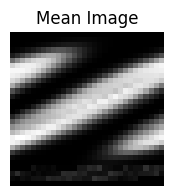

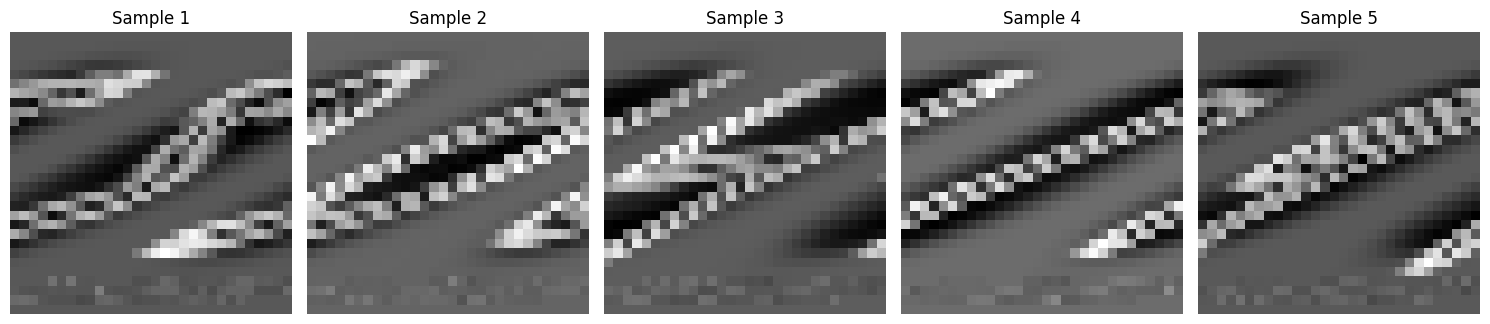

Number of components explaining ~80% variance: 91


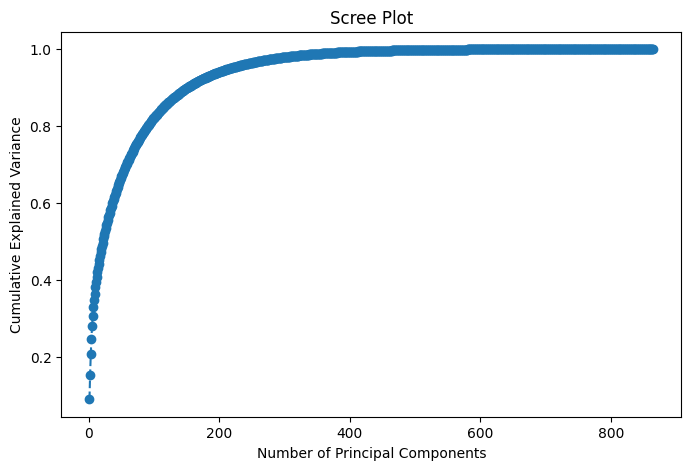

In [ ]:
Sobel_Hog_Reduced = pca(Sobel_HOG_Features)

In [ ]:
Sobel_Hog_Reduced.shape

(70000, 91)

# Phase 3: Decision Tree Hyperparameter Tuning

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

def train_decision_tree(x_train, y_train, x_test, y_test):
    # Define the Decision Tree model
    model = DecisionTreeClassifier(random_state=42)

    # Create a hyperparameter grid
    param_grid = {
        'max_depth': [15, 20, 25],
        'min_samples_split': [3, 5, 7],
        'min_samples_leaf': [3, 5, 7],
        'criterion': ['gini', 'entropy'],
    }

    # Set up GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=10,
        n_jobs=-1
    )

    # Train the model
    print("Starting Grid Search...")
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_

    # Evaluate the model
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Accuracy (CV):", grid_search.best_score_)

    # Compute train and test accuracies
    train_accuracy = best_model.score(x_train, y_train)
    test_accuracy = best_model.score(x_test, y_test)

    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    # Plot the decision tree
    plt.figure(figsize=(25, 15))
    plot_tree(
        best_model,
        feature_names=[f"Feature {i}" for i in range(x_train.shape[1])],
        class_names=[str(cls) for cls in np.unique(y_train)],
        filled=True,
        fontsize=10,
        max_depth=3,
        proportion=False
    )
    plt.title("Decision Tree")
    plt.show()

    return best_model, grid_search, test_accuracy


Applying decision tree for Sobel

Starting Grid Search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 7, 'min_samples_split': 3}
Best Accuracy (CV): 0.8459285714285713
Train Accuracy: 0.9258928571428572
Test Accuracy: 0.8504285714285714


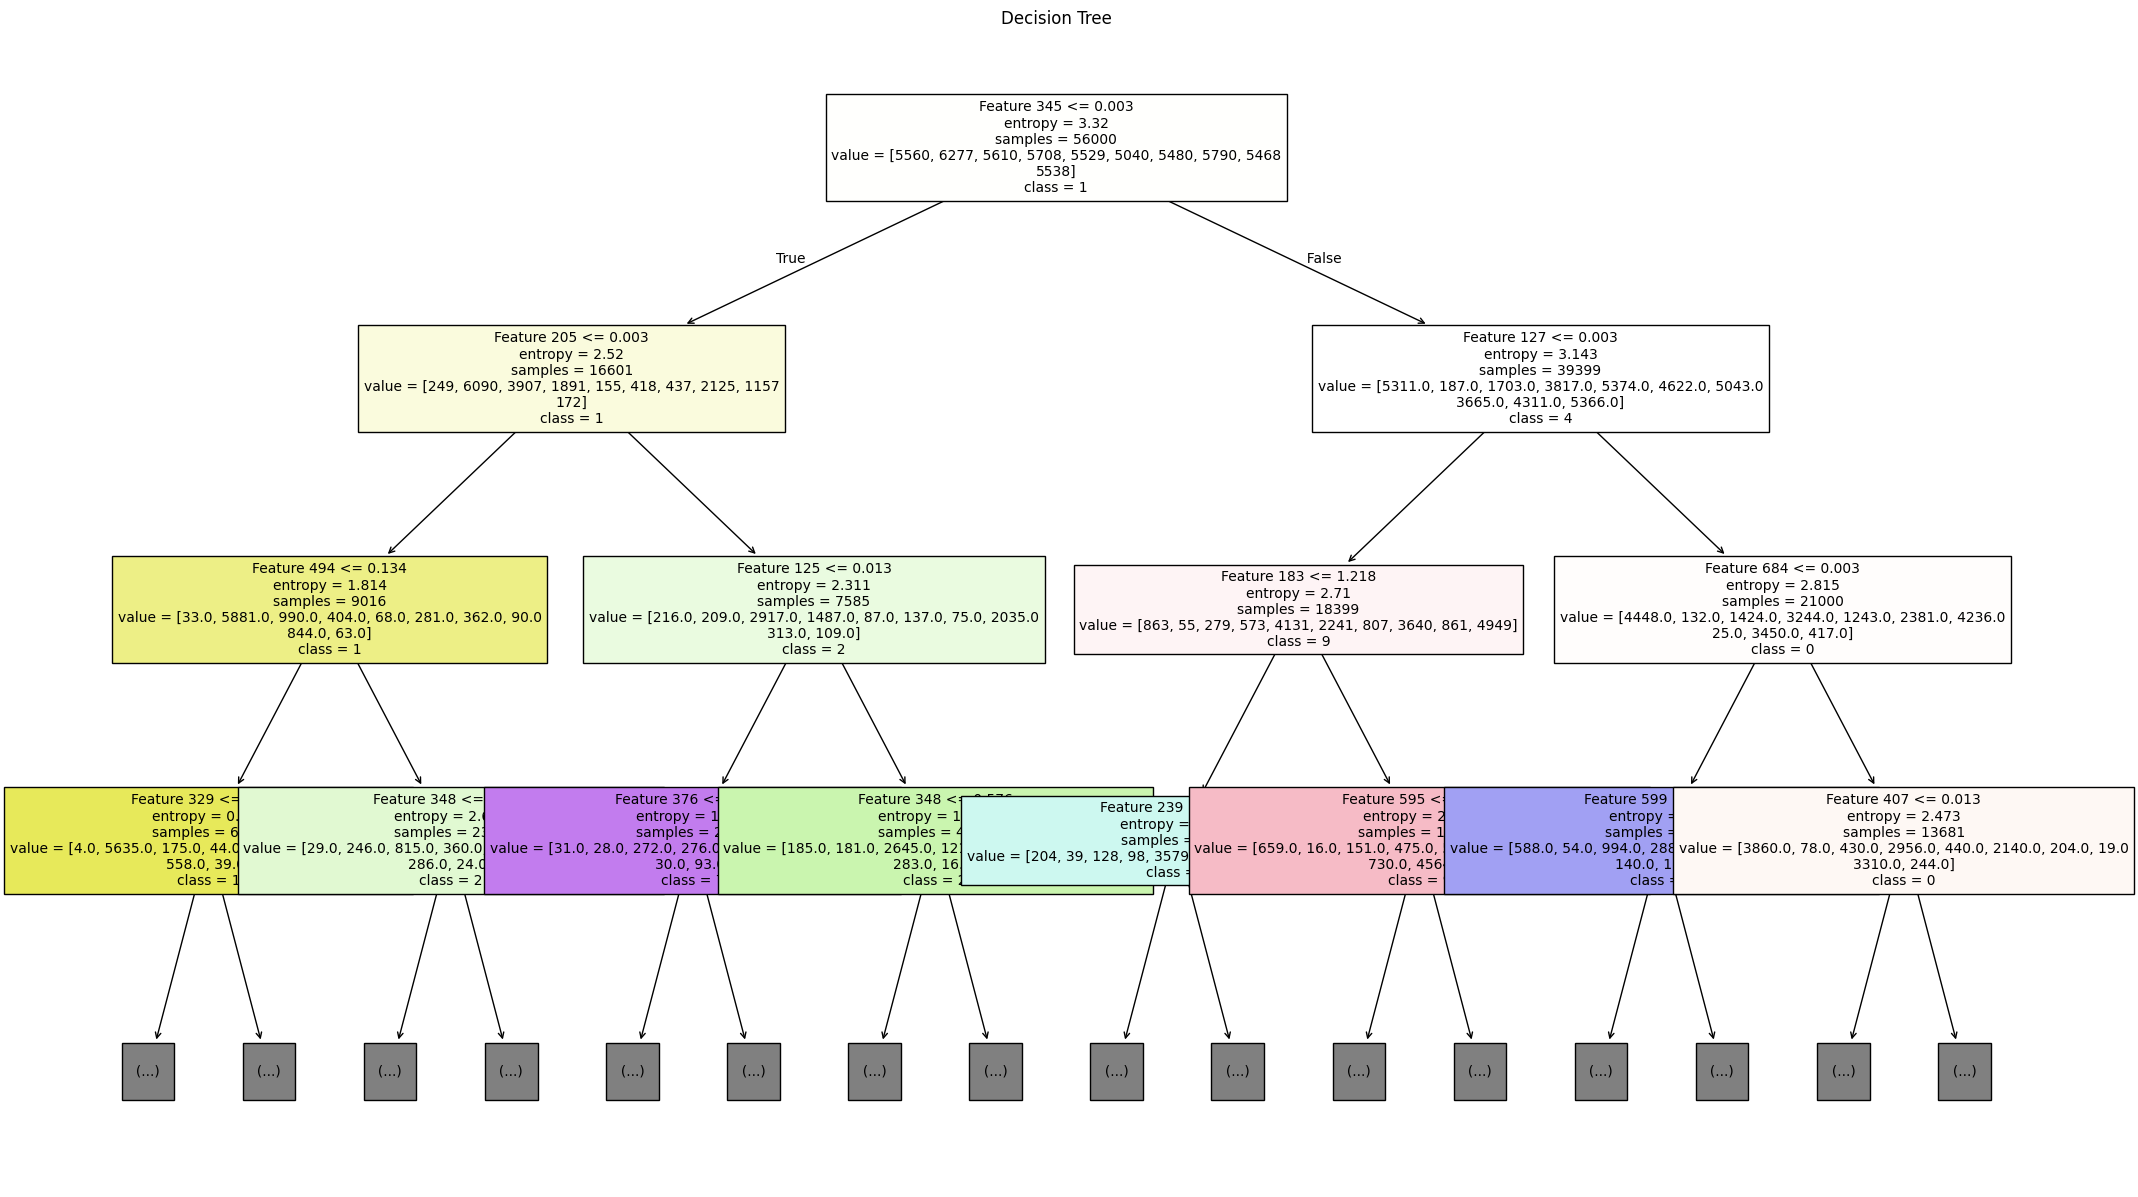

(DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=7,
                        min_samples_split=3, random_state=42),
 GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [15, 20, 25],
                          'min_samples_leaf': [3, 5, 7],
                          'min_samples_split': [3, 5, 7]},
              scoring='accuracy', verbose=3),
 0.8504285714285714)

In [ ]:
# Split the data back into training and testing sets
x_train_flat, x_test_flat, y_train, y_test = train_test_split(flattened_gradients, y_full, test_size=0.2, random_state=42)

# Call `train_decision_tree()` function with split datasets
train_decision_tree(x_train_flat, y_train, x_test_flat, y_test)


Applying decision tree for Sobel_HOG

Starting Grid Search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 7, 'min_samples_split': 3}
Best Accuracy (CV): 0.8164821428571429
Train Accuracy: 0.9195357142857142
Test Accuracy: 0.8283571428571429


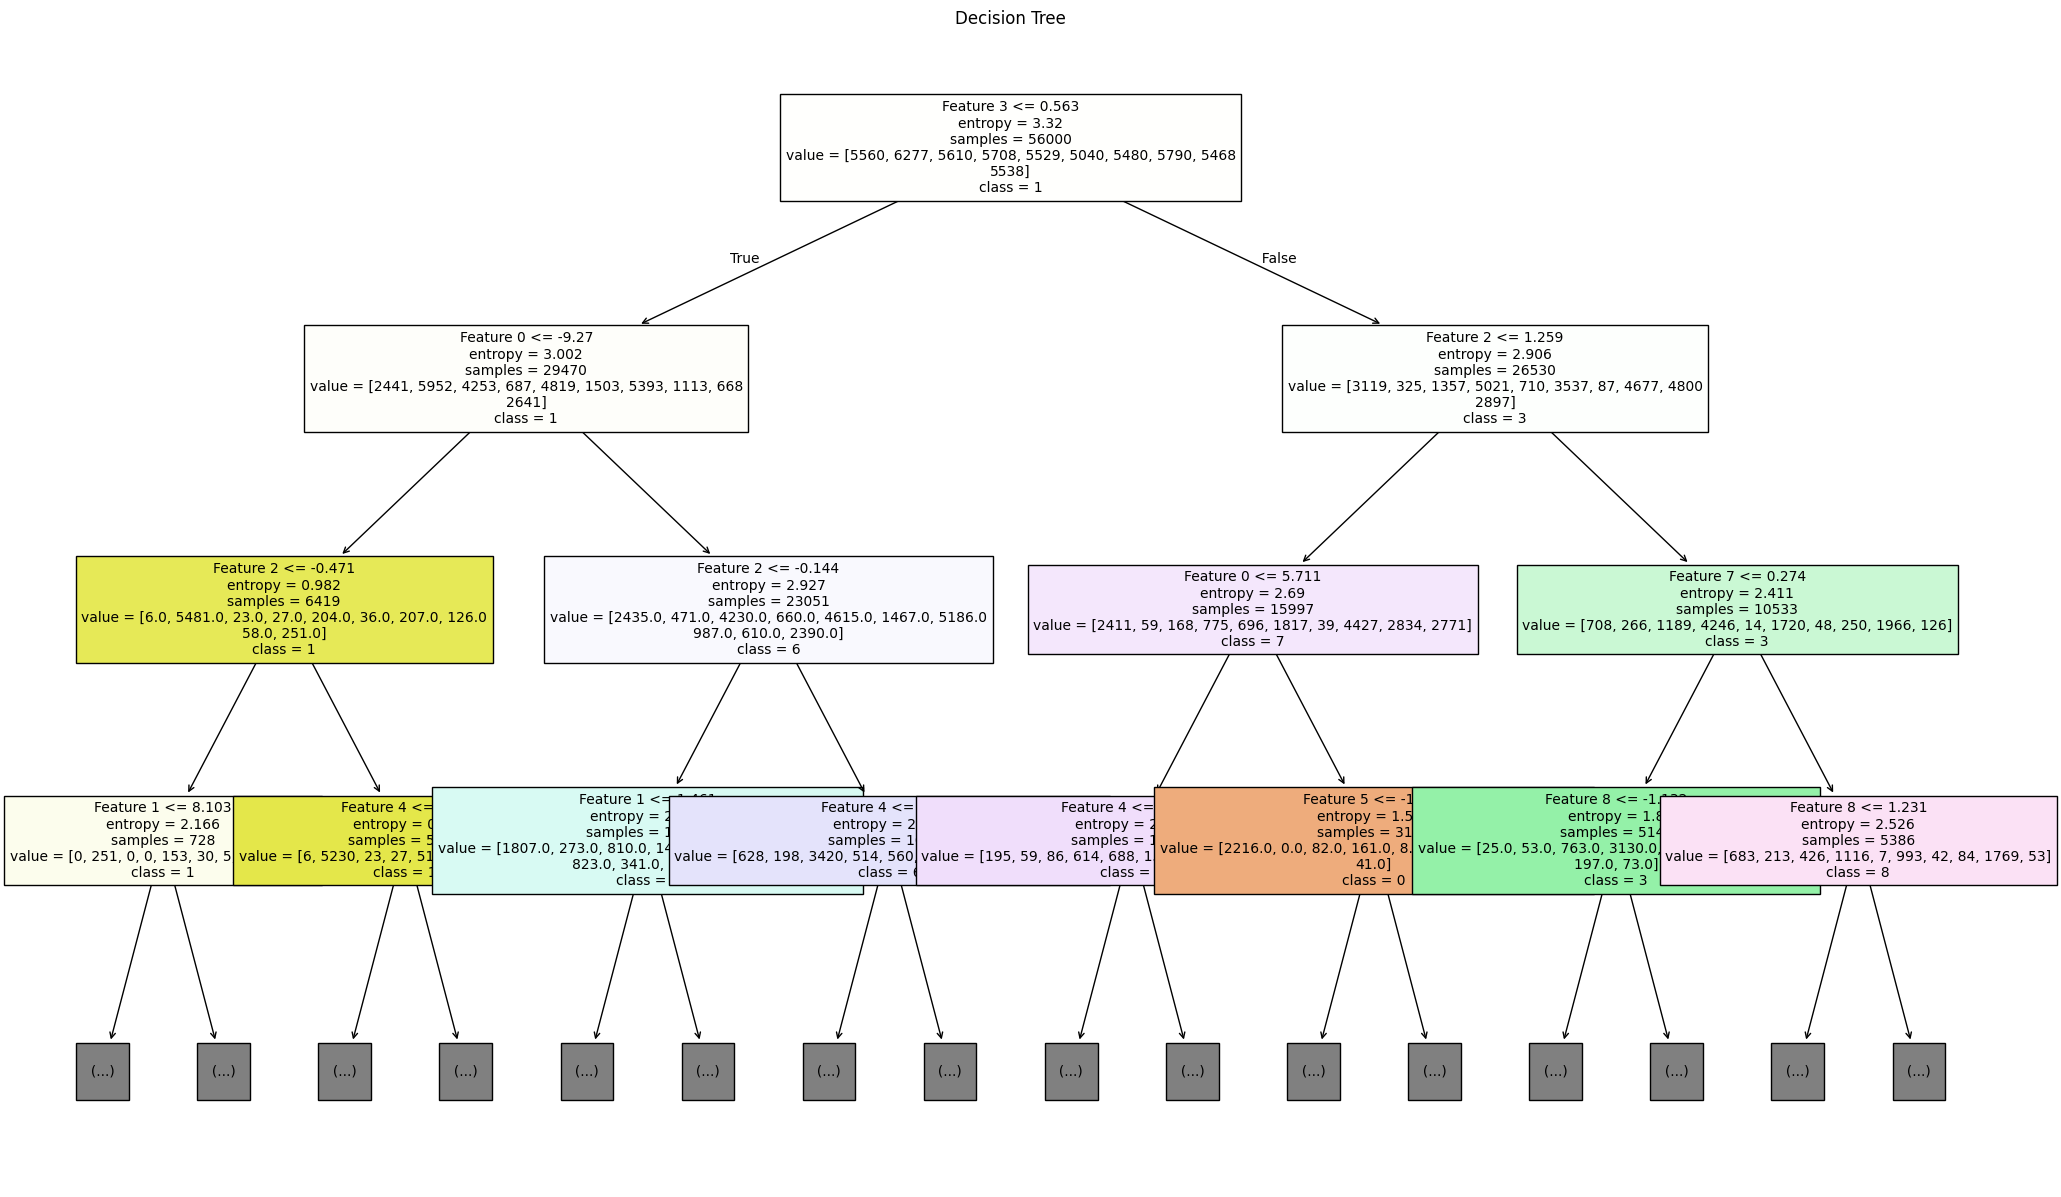

(DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=7,
                        min_samples_split=3, random_state=42),
 GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [15, 20, 25],
                          'min_samples_leaf': [3, 5, 7],
                          'min_samples_split': [3, 5, 7]},
              scoring='accuracy', verbose=3),
 0.8283571428571429)

In [ ]:
# Split the data back into training and testing sets
x_train_SobelHog, x_test_SobelHog, y_train, y_test = train_test_split(Sobel_Hog_Reduced, y_full, test_size=0.2, random_state=42)

# Call `train_decision_tree()` function with split datasets
train_decision_tree(x_train_SobelHog, y_train, x_test_SobelHog, y_test)

Applying decision tree for Sharpen_HOG

Starting Grid Search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 7, 'min_samples_split': 3}
Best Accuracy (CV): 0.8549464285714284
Train Accuracy: 0.9361071428571428
Test Accuracy: 0.8632857142857143


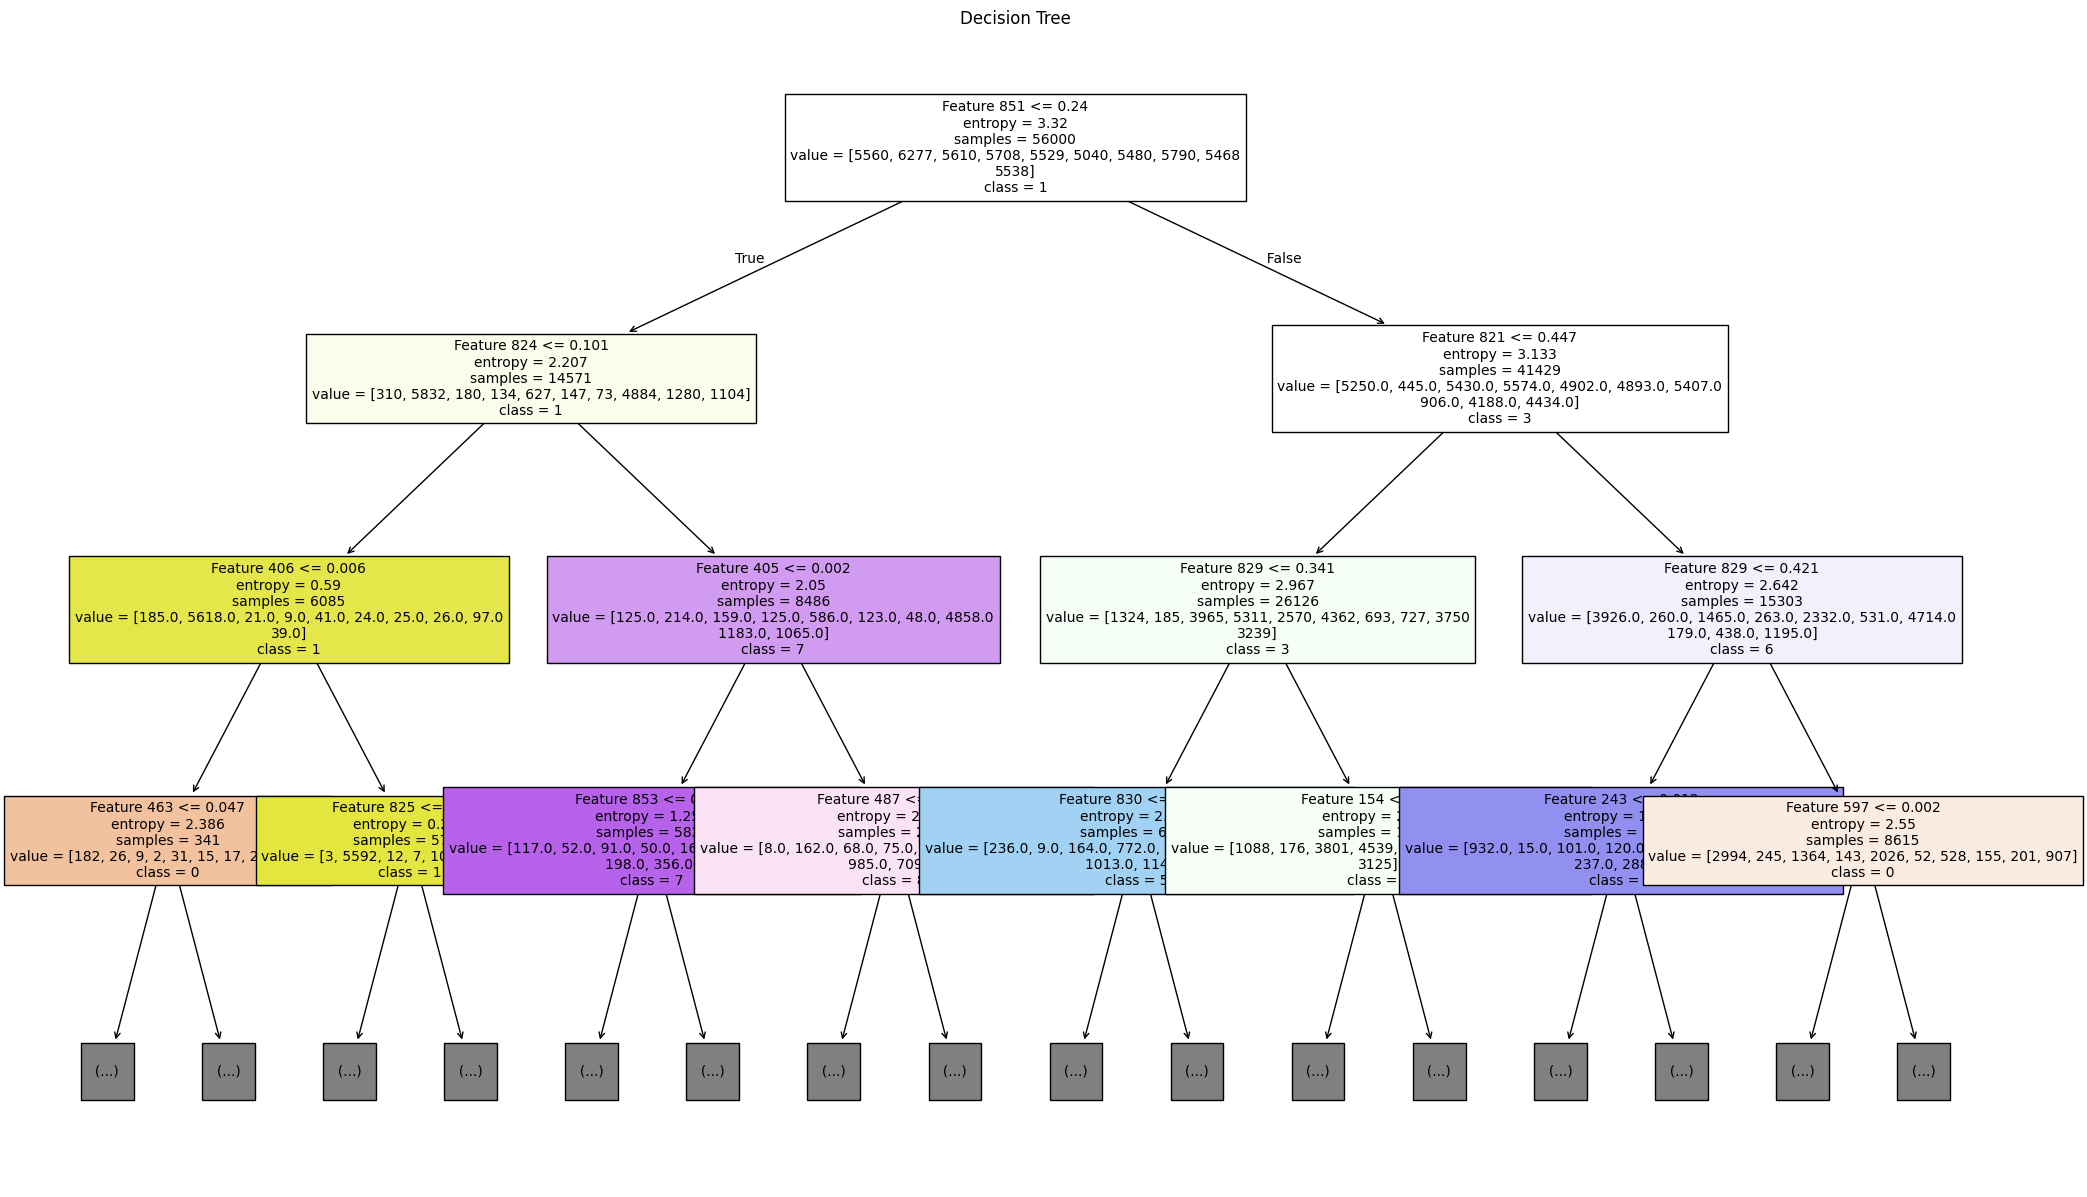

(DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=7,
                        min_samples_split=3, random_state=42),
 GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [15, 20, 25],
                          'min_samples_leaf': [3, 5, 7],
                          'min_samples_split': [3, 5, 7]},
              scoring='accuracy', verbose=10),
 0.8632857142857143)

In [ ]:
# Split the data back into training and testing sets
x_train_SharpenHog, x_test_SharpenHog, y_train, y_test = train_test_split(Sharpen_HOG_Features, y_full, test_size=0.2, random_state=42)

# Call `train_decision_tree()` function with split datasets
train_decision_tree(x_train_SharpenHog, y_train, x_test_SharpenHog, y_test)

Applying decision tree for raw data

Starting Grid Search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 7}
Best Accuracy (CV): 0.8469821428571429
Train Accuracy: 0.9601964285714286
Test Accuracy: 0.8575


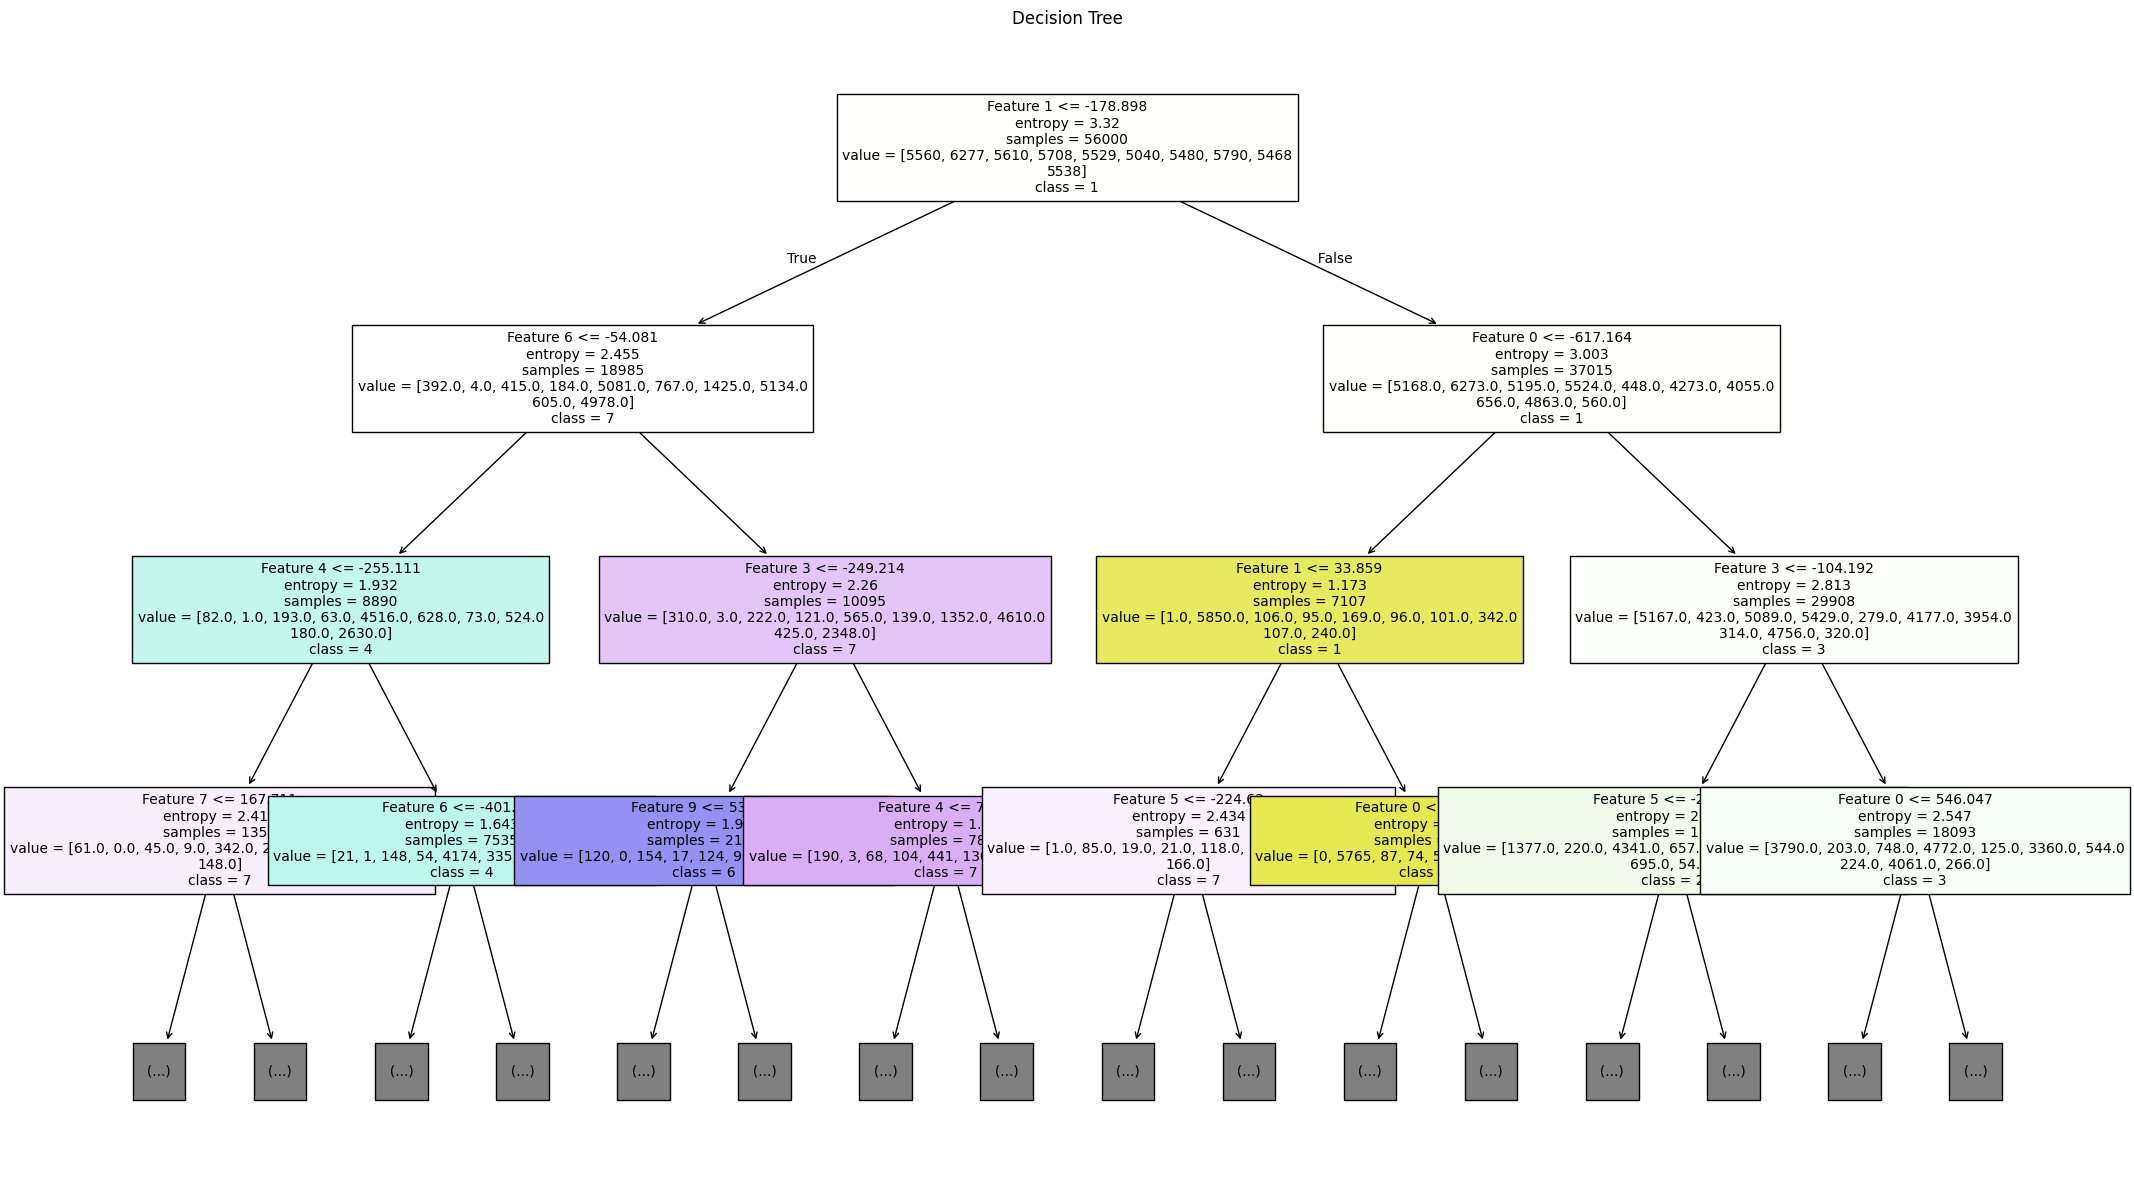

(DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=3,
                        min_samples_split=7, random_state=42),
 GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [10, 15, 20],
                          'min_samples_leaf': [3, 5, 7],
                          'min_samples_split': [3, 5, 7]},
              scoring='accuracy', verbose=10),
 0.8575)

In [ ]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()
y_full = np.concatenate((y_train, y_test), axis=0)

x_train_raw_data_reduced, x_test_raw_data_reduced, y_train_raw_data_reduced, y_test_raw_data_reduced = train_test_split(raw_data_reduced, y_full, test_size=0.2, random_state=42)

# Use the train_decision_tree() function
train_decision_tree(x_train_raw_data_reduced, y_train_raw_data_reduced, x_test_raw_data_reduced, y_test_raw_data_reduced)

SVM implementation

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

def train_and_evaluate_svm(x_train, y_train, x_test, y_test, parameter_modes, description):
    print(f"\nSVM Results for {description}:")
    for i, params in enumerate(parameter_modes):
        svm = SVC(**params, random_state=42)
        svm.fit(x_train, y_train)
        y_pred = svm.predict(x_test)

        print(f"--- Mode {i + 1}: Parameters: {params} ---")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Classification Report:")
        print(classification_report(y_test, y_pred))


SVM with 3 parameters for Sobel filter + HOG

In [ ]:
# SVM parameter modes for Sobel + HOG features
svm_params_sobel_hog = [
    {'kernel': 'linear', 'C': 1},
    {'kernel': 'rbf', 'C': 10, 'gamma': 0.1},
    {'kernel': 'poly', 'C': 1, 'degree': 3},
]

x_train_SobelHog, x_test_SobelHog, y_train, y_test = train_test_split(Sobel_HOG_Features, y_full, test_size=0.2, random_state=42)


# Call the SVM function for Sobel + HOG features
train_and_evaluate_svm(
    x_train_SobelHog,
    y_train,
    x_test_SobelHog,
    y_test,
    svm_params_sobel_hog,
    description="Sobel + HOG Filter"
)


SVM Results for Sobel + HOG Filter:
--- Mode 1: Parameters: {'kernel': 'linear', 'C': 1} ---
Accuracy: 0.9663571428571428
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1343
           1       0.98      0.99      0.98      1600
           2       0.95      0.97      0.96      1380
           3       0.96      0.95      0.96      1433
           4       0.95      0.98      0.96      1295
           5       0.96      0.96      0.96      1273
           6       0.98      0.98      0.98      1396
           7       0.97      0.96      0.97      1503
           8       0.97      0.94      0.95      1357
           9       0.96      0.95      0.95      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



SVM with 3 parameters for raw data

In [ ]:
# SVM parameter modes for raw data
svm_params_raw = [
    {'kernel': 'linear', 'C': 1},
    {'kernel': 'rbf', 'C': 10, 'gamma': 0.1},
    {'kernel': 'poly', 'C': 1, 'degree': 3},
]

# Call the SVM function for raw data
train_and_evaluate_svm(
    x_train_raw_data_reduced,
    y_train_raw_data_reduced,
    x_test_raw_data_reduced,
    y_test_raw_data_reduced,
    svm_params_raw,
    description="Raw Data"
)

# Phase 4: Model Accuracy Analysis and Metrics

Loading the Decision Tree model from Drive...

Classification Report for SVM (Sobel + HOG):

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1343
           1       0.96      0.98      0.97      1600
           2       0.89      0.91      0.90      1380
           3       0.87      0.88      0.87      1433
           4       0.88      0.90      0.89      1295
           5       0.87      0.85      0.86      1273
           6       0.95      0.95      0.95      1396
           7       0.93      0.92      0.92      1503
           8       0.89      0.86      0.88      1357
           9       0.89      0.88      0.88      1420

    accuracy                           0.91     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.91      0.91      0.91     14000



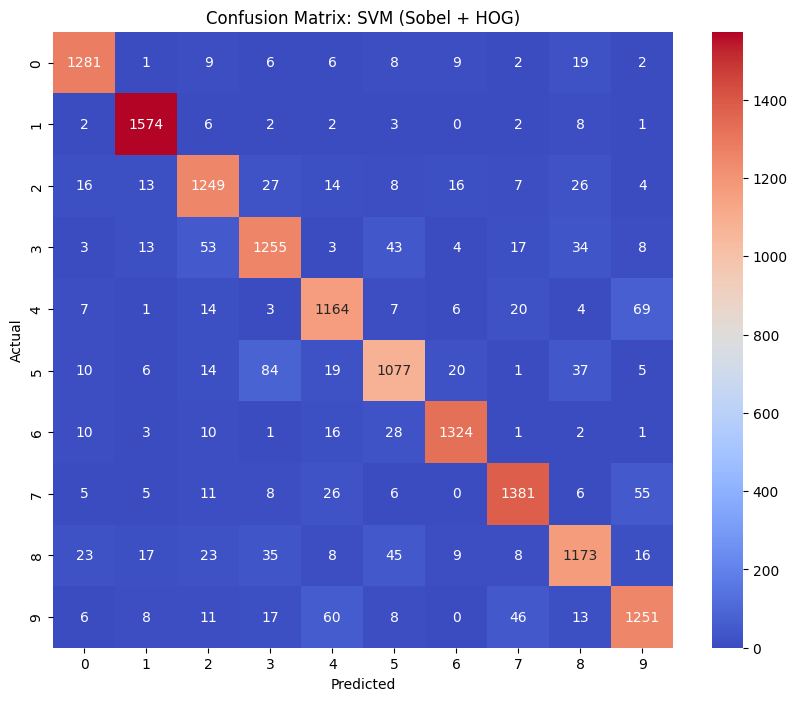

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path where the model is saved
model_path = '/content/drive/My Drive/models/best_decision_tree_model.pkl'

# Load the pre-trained model
print("Loading the Decision Tree model from Drive...")
best_model = joblib.load(model_path)

# Define the SVM model with the specified parameters
svm_model = SVC(kernel='linear', C=1, random_state=42)

# Predict labels using the best Decision Tree model
dt_pred = best_model.predict(x_test_SobelHog)

# Train the SVM model on Sobel + HOG features
svm_model.fit(x_train_SobelHog, y_train)

# Predict the labels on the test set
svm_pred_sobel_hog = svm_model.predict(x_test_SobelHog)

# Classification report for SVM
print("\nClassification Report for SVM (Sobel + HOG):\n")
svm_classification_report = classification_report(y_test, svm_pred_sobel_hog, target_names=[str(i) for i in range(10)])
print(svm_classification_report)

# Confusion matrix for SVM
svm_confusion_matrix = confusion_matrix(y_test, svm_pred_sobel_hog)

# Plot the confusion matrix for SVM
plt.figure(figsize=(10, 8))
sns.heatmap(svm_confusion_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix: SVM (Sobel + HOG)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for Decision Tree
dt_confusion_matrix = confusion_matrix(y_test, dt_pred)


Loading the Decision Tree model from Drive...
Evaluating the loaded Decision Tree model...

Classification Report for Decision Tree (Sobel + HOG):

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1343
           1       0.94      0.95      0.95      1600
           2       0.82      0.82      0.82      1380
           3       0.74      0.74      0.74      1433
           4       0.81      0.82      0.81      1295
           5       0.78      0.75      0.76      1273
           6       0.92      0.92      0.92      1396
           7       0.87      0.84      0.85      1503
           8       0.74      0.73      0.74      1357
           9       0.77      0.80      0.78      1420

    accuracy                           0.83     14000
   macro avg       0.83      0.83      0.83     14000
weighted avg       0.83      0.83      0.83     14000



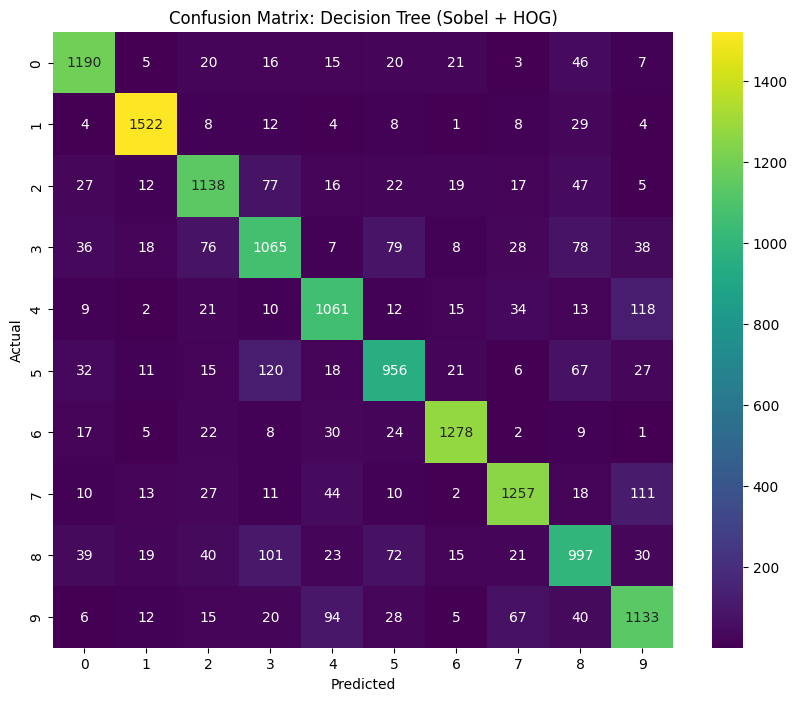

Decision Tree Test Accuracy: 0.8284
SVM Test Accuracy: 0.9092


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib
from google.colab import drive

# Define the path where the model is saved
model_path = '/content/drive/My Drive/models/best_decision_tree_model.pkl'

# Load the pre-trained model
print("Loading the Decision Tree model from Drive...")
best_model = joblib.load(model_path)

x_train_SobelHog, x_test_SobelHog, y_train, y_test = train_test_split(Sobel_Hog_Reduced, y_full, test_size=0.2, random_state=42)

# Assuming Sobel_HOG_Features and y_full are already defined
#x_train_SobelHog, x_test_SobelHog, y_train, y_test = train_test_split(Sobel_HOG_Features, y_full, test_size=0.2, random_state=42)

# Evaluate the Decision Tree
print("Evaluating the loaded Decision Tree model...")
dt_pred_sobel_hog = best_model.predict(x_test_SobelHog)

print("\nClassification Report for Decision Tree (Sobel + HOG):\n")
dt_classification_report = classification_report(y_test, dt_pred_sobel_hog, target_names=[str(i) for i in range(10)])
print(dt_classification_report)

# Confusion Matrix for Decision Tree
dt_confusion_matrix = confusion_matrix(y_test, dt_pred_sobel_hog)
plt.figure(figsize=(10, 8))
sns.heatmap(dt_confusion_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix: Decision Tree (Sobel + HOG)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Comparing Model Accuracies
dt_test_accuracy = best_model.score(x_test_SobelHog, y_test)
svm_test_accuracy = svm_model.score(x_test_SobelHog, y_test)

print(f"Decision Tree Test Accuracy: {dt_test_accuracy:.4f}")
print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")


# Phase 5: Overfitting and Pruning

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import joblib
from google.colab import drive

# Load the best pre-trained Decision Tree model from Google Drive
best_model_path = '/content/drive/My Drive/models/best_decision_tree_model.pkl'
print("Loading Best Model from Drive...")
best_model = joblib.load(best_model_path)

x_train_SobelHog, x_test_SobelHog, y_train, y_test = train_test_split(Sobel_Hog_Reduced, y_full, test_size=0.2, random_state=42)

# Assuming Sobel_HOG_Features and y_full are already defined
#x_train_SobelHog, x_test_SobelHog, y_train, y_test = train_test_split(Sobel_HOG_Features, y_full, test_size=0.2, random_state=42)

# Evaluate Best Model
print("\nEvaluating Best Decision Tree Model...")
best_pred = best_model.predict(x_test_SobelHog)
print("\nClassification Report for Best Decision Tree Model:")
print(classification_report(y_test, best_pred))

# Overfitted Decision Tree
print("\nTraining Overfitted Decision Tree...")
overfit_dt = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
overfit_dt.fit(x_train_SobelHog, y_train)

# Evaluate Overfitted Model
overfit_pred = overfit_dt.predict(x_test_SobelHog)
print("\nClassification Report for Overfitted Decision Tree (Sobel + HOG):")
print(classification_report(y_test, overfit_pred))

# Pruned Decision Tree
print("\nTraining Pruned Decision Tree...")
pruned_dt = DecisionTreeClassifier(max_depth=15, min_samples_split=10, min_samples_leaf=5, random_state=42)
pruned_dt.fit(x_train_SobelHog, y_train)

# Evaluate Pruned Model
pruned_pred = pruned_dt.predict(x_test_SobelHog)
print("\nClassification Report for Pruned Decision Tree (Sobel + HOG):")
print(classification_report(y_test, pruned_pred))

# Comparing Model Performance
print("\nComparing Overfitted, Pruned, and Best Decision Tree Models:\n")
best_train_accuracy = best_model.score(x_train_SobelHog, y_train)
best_test_accuracy = best_model.score(x_test_SobelHog, y_test)
overfit_train_accuracy = overfit_dt.score(x_train_SobelHog, y_train)
overfit_test_accuracy = overfit_dt.score(x_test_SobelHog, y_test)
pruned_train_accuracy = pruned_dt.score(x_train_SobelHog, y_train)
pruned_test_accuracy = pruned_dt.score(x_test_SobelHog, y_test)

print(f"Best Decision Tree - Train Accuracy: {best_train_accuracy:.4f}, Test Accuracy: {best_test_accuracy:.4f}")
print(f"Overfitted Decision Tree - Train Accuracy: {overfit_train_accuracy:.4f}, Test Accuracy: {overfit_test_accuracy:.4f}")
print(f"Pruned Decision Tree - Train Accuracy: {pruned_train_accuracy:.4f}, Test Accuracy: {pruned_test_accuracy:.4f}")


Loading Best Model from Drive...

Evaluating Best Decision Tree Model...

Classification Report for Best Decision Tree Model:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1343
           1       0.94      0.95      0.95      1600
           2       0.82      0.82      0.82      1380
           3       0.74      0.74      0.74      1433
           4       0.81      0.82      0.81      1295
           5       0.78      0.75      0.76      1273
           6       0.92      0.92      0.92      1396
           7       0.87      0.84      0.85      1503
           8       0.74      0.73      0.74      1357
           9       0.77      0.80      0.78      1420

    accuracy                           0.83     14000
   macro avg       0.83      0.83      0.83     14000
weighted avg       0.83      0.83      0.83     14000


Training Overfitted Decision Tree...

Classification Report for Overfitted Decision Tree (Sobel + HOG):
          